In [399]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Part I: Breast Cancer Dataset

In the previous assignments, we looked at the breast cancer dataset, where we attempted to identify whether a tumour is malignant or benign - to then be able to treat it correctly. We understood that accuracy was probably not a accurate representation of any classification model, as we would want to make sure that we treated positive cases and not negative cases, likewise, and more importantly, catching all the positive cases. Therefore, precision and recall were better suited metrics to assess the binary classification model.

In this assignment, we revisit this dataset, with the same goals in mind. A logistic regression and decision tree model will be fitted to predict the tumour status. Additionally, we aim to also find the importance of cell nucleus features, and we can do this using Principal Component Analysis (PCA).

**Loading in the Dataset**

In [400]:
breast_cancer = pd.read_csv('../datasets/breast-cancer.csv', sep=',')

In [401]:
# Quick look at the dataframe
breast_cancer.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


A glance at the dataframe shows us the diagnosis (prediction variable) and the other 10 features. Additionally, we can remove the id column, as it is not useful in our model. Likewise, it is good practice to inspect any anomaly or invalid cases in the data before modelling.

In [402]:
# drop the id column
breast_cancer = breast_cancer.drop('id', axis=1)

In [403]:
# Check for any missing values in the dataset
null_count = np.array(breast_cancer.isnull().sum())
na_counts = np.array(breast_cancer.isna().sum())
pd.DataFrame(np.vstack((null_count, na_counts)), columns=breast_cancer.columns, index=['null_count','na_counts'])

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
null_count,0,0,0,0,0,0,0,0,0,0,0
na_counts,0,0,0,0,0,0,0,0,0,0,0


In [404]:
breast_cancer.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440


We can tell that the data looks quite okay. However, we can see that a particular feature (area_mean) has much higher values compared to the other features, and variance is much larger as well. 

No null or invalid values, which is good.

With all machine learning algorithms, we first need to seperate the dataset into training and test sets. We use a 85/15 split.

In [405]:
from sklearn.model_selection import train_test_split

X = breast_cancer.iloc[:,1:11]
y = breast_cancer.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=5508)

In [406]:
# Inspect the dimensions of the training and test sets, for both y and x 
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((483, 10), (483,), (86, 10), (86,))

In this section, we will be exploring the dataset, and fitting a logistic regression model and a decision tree model to predict the diagnosis of a tumour. Additionally, we will be using PCA to find the most important features in the dataset.

Therefore, we need to scale the data prior to model fitting when doing PCA. Do note that for a logistic regression model, scaling is not necessary, as the coefficients will be scaled accordingly. However, for a decision tree model, scaling is necessary, as the tree will be built based on the scaled values. We can then use the StandardScaler() function to scale the data.

In [407]:
# Scaling the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# turn it back into dataframe
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

**1a. Logistic Regression**

In this section, we build a logistic regression model on the training set to predict tumour status. Additionally, we want to find the optimal hyperparameters that we achieve the best model. We first start of with the base model with no hyperparameters.

In [408]:
from sklearn.linear_model import LogisticRegression

bc_logreg_base = LogisticRegression(random_state=5508, max_iter=10000)
bc_logreg_base.fit(X_train.values, y_train)

LogisticRegression(max_iter=10000, random_state=5508)

In [409]:
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import classification_report

# Start by evaluating the model on the training set
y_train_pred = bc_logreg_base.predict(X_train.values)
y_test_pred = bc_logreg_base.predict(X_test.values)
target_names = bc_logreg_base.classes_

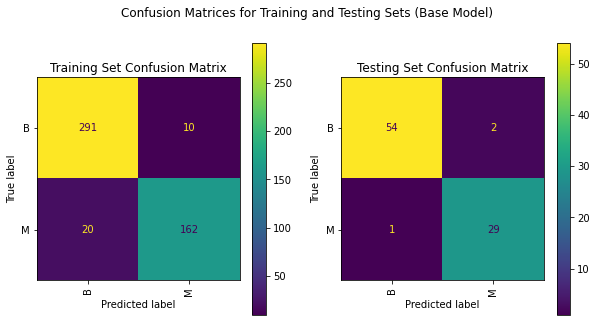

In [410]:
# Function to display the confusion matrix for the training and testing sets
def display_confusion_matrix(y_train, y_test, y_train_pred, y_test_pred, target_names, model_name):
    test_cm = confusion_matrix(y_test, y_test_pred)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=target_names)
    train_cm = confusion_matrix(y_train, y_train_pred)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=target_names)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].set_title('Training Set Confusion Matrix')
    disp_train.plot(ax=axs[0], xticks_rotation='vertical')
    axs[1].set_title('Testing Set Confusion Matrix')
    disp_test.plot(ax=axs[1], xticks_rotation='vertical')
    fig.suptitle(f'Confusion Matrices for Training and Testing Sets ({model_name})')
    plt.show()
    
# Base Model Confusion Matrix for 2 class benign/malignant classification
display_confusion_matrix(y_train, y_test, y_train_pred, y_test_pred, target_names, 'Base Model')

In [411]:
# Classification report
def summarize_classification(y_train, y_test, y_train_pred, y_test_pred, target_names):
    print('Training Set Report:')
    print(classification_report(y_train, y_train_pred, target_names=target_names))
    print('Testing Set Report:')
    print(classification_report(y_test, y_test_pred, target_names=target_names))

summarize_classification(y_train, y_test, y_train_pred, y_test_pred, target_names)

Training Set Report:
              precision    recall  f1-score   support

           B       0.94      0.97      0.95       301
           M       0.94      0.89      0.92       182

    accuracy                           0.94       483
   macro avg       0.94      0.93      0.93       483
weighted avg       0.94      0.94      0.94       483

Testing Set Report:
              precision    recall  f1-score   support

           B       0.98      0.96      0.97        56
           M       0.94      0.97      0.95        30

    accuracy                           0.97        86
   macro avg       0.96      0.97      0.96        86
weighted avg       0.97      0.97      0.97        86



From the above model predictions and performance metrics, we can see that our base model might not be the best at catching the malignant tumors. The recall parameter tells us the number of classified positive cases as a proportion of true positive cases. This metric is important for both catching the malignant tumors accurately. The precision parameter is more important to catching the benign tumors as we do not want to misclassify them and treat them using malignant treatments.

We continue to find the best model using hyperparameter tuning and then cross-validation.

In [412]:
# Hyperparameter tuning for logistic regression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score
from sklearn.model_selection import cross_validate

# grid of hyperparameters to search
param_grid = {'C': [0.001, 0.01, 0.1, 1, 5, 10, 100],
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear','saga'],
                'class_weight': ['balanced', None],
}

bc_logreg_cv = GridSearchCV(bc_logreg_base, param_grid, cv=5, scoring = make_scorer(recall_score, pos_label='M'), n_jobs=-1)
# Fit to the training data
bc_logreg_cv.fit(X_train.values, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=10000, random_state=5508),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 5, 10, 100],
                         'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring=make_scorer(recall_score, pos_label=M))

Upon using the Grid Search CV, we can look at the best hyperparameters that gives us the best recall score on Malignant instances.

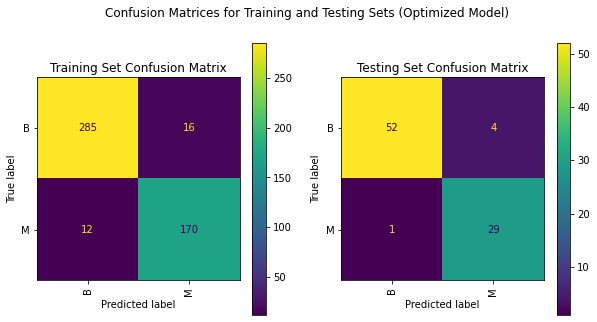

Training Set Report:
              precision    recall  f1-score   support

           B       0.96      0.95      0.95       301
           M       0.91      0.93      0.92       182

    accuracy                           0.94       483
   macro avg       0.94      0.94      0.94       483
weighted avg       0.94      0.94      0.94       483

Testing Set Report:
              precision    recall  f1-score   support

           B       0.98      0.93      0.95        56
           M       0.88      0.97      0.92        30

    accuracy                           0.94        86
   macro avg       0.93      0.95      0.94        86
weighted avg       0.95      0.94      0.94        86



In [413]:
# Best model
bc_logreg_best = bc_logreg_cv.best_estimator_
bc_logreg_best.fit(X_train.values, y_train)

y_train_best = bc_logreg_best.predict(X_train.values)
y_test_best = bc_logreg_best.predict(X_test.values)

display_confusion_matrix(y_train, y_test, y_train_best, y_test_best, target_names, 'Optimized Model')
summarize_classification(y_train, y_test, y_train_best, y_test_best, target_names)

The recall scores on the malignant observations have increased for the training set, but remains the same for the test set at 0.97. We favour the recall score over the precision score for the malignant as a trade off as we want to make sure that we catch all the malignant tumors. The precision score is as we can see increased for the begnin tumors, which is good as we do not want to misclassify them as malignant and treat them using malignant treatments.

Therfore, this is exactly what we were after. However, to acertain that our new logistic regression model with the optimal hyperparameters is much better than the base model, we can use k-fold cross validation using k=5. 

In [414]:
# Cross Validation, prepare the scorers on each class
scorers = {
    'precision': make_scorer(precision_score, pos_label='B'),
    'recall': make_scorer(recall_score, pos_label='M')
}

def cross_validation(model, X_train, y_train, cv=5):
    cv_scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scorers)
    return cv_scores
    
cv_scores_base = cross_validation(bc_logreg_base, X_train, y_train, cv=5)
cv_scores_best = cross_validation(bc_logreg_best, X_train, y_train, cv=5)

In [415]:
print(f"Base Model Precision: {cv_scores_base['test_precision'].mean()}, Recall: {cv_scores_base['test_recall'].mean()}")
print(f"Optimal Model Precision: {cv_scores_best['test_precision'].mean()}, Recall: {cv_scores_best['test_recall'].mean()}")

Base Model Precision: 0.9335364051153526, Recall: 0.884984984984985
Optimal Model Precision: 0.9504965353519301, Recall: 0.9177177177177176


The recommended choice, given a choice between the 2 logistic regression models for identifying a benign or malignant tumor classification problem would have to be the latter **optimal model**.

In [416]:
# Optimal Hyperparameters for the LR model using GridSearchCV
bc_logreg_cv.best_params_

{'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}

**1b. Decision Tree Classifier**

In the second part of the classification prediction, we would like to achieve the same goals, but this time using a decision tree classsifier.
Similarly, we start with the base model and then work our way up to find the optimal decision tree.

In [417]:
from sklearn.tree import DecisionTreeClassifier

# Base model
bc_tree_base = DecisionTreeClassifier(random_state=5508)
bc_tree_base.fit(X_train.values, y_train)
bc_tree_base_train_pred = bc_tree_base.predict(X_train.values)
bc_tree_base_pred = bc_tree_base.predict(X_test.values)

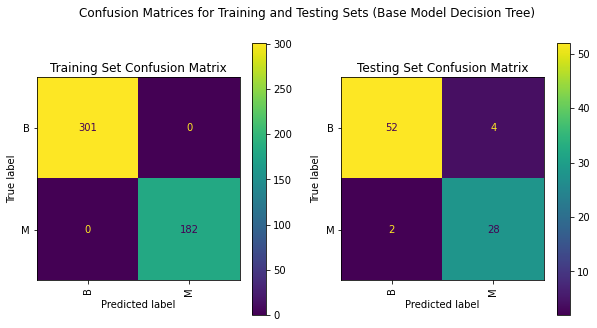

Training Set Report:
              precision    recall  f1-score   support

           B       1.00      1.00      1.00       301
           M       1.00      1.00      1.00       182

    accuracy                           1.00       483
   macro avg       1.00      1.00      1.00       483
weighted avg       1.00      1.00      1.00       483

Testing Set Report:
              precision    recall  f1-score   support

           B       0.96      0.93      0.95        56
           M       0.88      0.93      0.90        30

    accuracy                           0.93        86
   macro avg       0.92      0.93      0.92        86
weighted avg       0.93      0.93      0.93        86



In [418]:
display_confusion_matrix(y_train, y_test, bc_tree_base_train_pred, bc_tree_base_pred, target_names,'Base Model Decision Tree')
summarize_classification(y_train, y_test, bc_tree_base_train_pred, bc_tree_base_pred, target_names)

If we look at our model results from the metrics and confusion table above, we can observe that precision, recall and accuracy scores are perfect in the training set. However, this is not the case with the test set - which is a good indication that our decision tree model might be overfitted to the training data. 

Therefore, we might want to find a more generalised decision tree, which might be require pruning. Once again, we tune the hyperparameters and cross-validate it. 

In [419]:
# Hyperparameter tuning for decision tree using GridSearchCV
param_grid = {'criterion': ['gini', 'entropy'],
                'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                'class_weight': ['balanced', None],}
bc_tree_cv = GridSearchCV(bc_tree_base, param_grid, scoring=make_scorer(recall_score, pos_label="M"), cv=5, n_jobs=-1)
bc_tree_cv.fit(X_train.values, y_train)
# a quick look at the best parameters
bc_tree_cv.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [420]:
# Evaluate the model with the best parameters
bc_tree_best = bc_tree_cv.best_estimator_
bc_tree_best.fit(X_train.values, y_train)
bc_tree_best_train_pred = bc_tree_best.predict(X_train.values)
bc_tree_best_pred = bc_tree_best.predict(X_test.values)

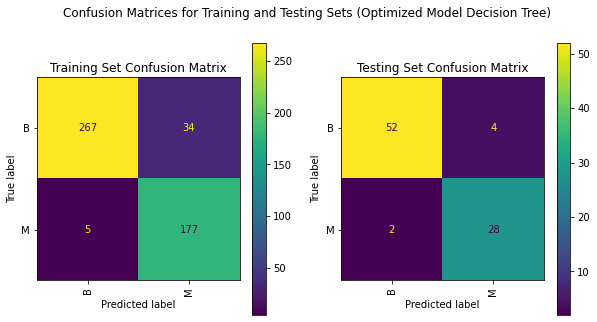

Training Set Report:
              precision    recall  f1-score   support

           B       0.98      0.89      0.93       301
           M       0.84      0.97      0.90       182

    accuracy                           0.92       483
   macro avg       0.91      0.93      0.92       483
weighted avg       0.93      0.92      0.92       483

Testing Set Report:
              precision    recall  f1-score   support

           B       0.96      0.93      0.95        56
           M       0.88      0.93      0.90        30

    accuracy                           0.93        86
   macro avg       0.92      0.93      0.92        86
weighted avg       0.93      0.93      0.93        86



In [421]:
# Confusion matrix and classification report
display_confusion_matrix(y_train, y_test, bc_tree_best_train_pred, bc_tree_best_pred, target_names, 'Optimized Model Decision Tree')
summarize_classification(y_train, y_test, bc_tree_best_train_pred, bc_tree_best_pred, target_names)

From the model above, we can see that the model has generalised well to the test set, as the recall scores are much the same than the base model. Despite the precision score being lower, we are more interested in the recall score, as we want to make sure that we catch all the malignant tumors. Therefore, we can conclude that the optimal decision tree model is better than the base model, in terms of it not overfitting to the training data and generalising well to the test set, and also retaining a good recall score. 

The hyperparameters selected for the optimal decision tree model are as follows:
- 'class_weight': 'balanced'
- 'criterion': 'entropy'
- 'max_depth': 2
- 'min_samples_leaf': 1
- 'min_samples_split': 2

In [422]:
# Perform Cross validation between the base and optimal decsiion tree models
cv_scores_base = cross_validation(bc_tree_base, X_train, y_train, cv=5)
cv_scores_best = cross_validation(bc_tree_best, X_train, y_train, cv=5)

print(f"Base Model Precision: {cv_scores_base['test_precision'].mean()}, Recall: {cv_scores_base['test_recall'].mean()}")
print(f"Optimal Model Precision: {cv_scores_best['test_precision'].mean()}, Recall: {cv_scores_best['test_recall'].mean()}")

Base Model Precision: 0.9370517472826048, Recall: 0.895045045045045
Optimal Model Precision: 0.975169725078981, Recall: 0.9615615615615616


We see here that the precision on benign has increased, and recall on malignant has increased as well for the optimal model. Therefore, the optimal decison tree model is better than the base model and we pick that.

**2. Feature Importance**

After looking at the two models that we have fit earlier, as well as the optimal models being trained, we want to look at the features that perhaps contribute the most to the prediction of the tumour status. For the logistic regression, we can take a look at the coefficients of the model, and for the decision tree, we can look at which feature is being used as the largest information gain.

In [423]:
# Logistic Regression Coefficients
# Get the coefficients from the logistic regression model
logreg_coef = pd.DataFrame(bc_logreg_best.coef_, columns=X_train.columns, index=['Coefficients']).T
# Sort the values by the absolute value of the coefficients
logreg_coef['abs'] = logreg_coef['Coefficients'].abs()
logreg_coef.sort_values(by='abs', ascending=False, inplace=True)
logreg_coef.drop(columns='abs', inplace=True)
logreg_coef

,Coefficients
area_mean,3.103620
concave points_mean,2.029002
texture_mean,1.384317
smoothness_mean,0.783628
concavity_mean,0.589369
fractal_dimension_mean,-0.348289
symmetry_mean,0.260186
radius_mean,0.000000
perimeter_mean,0.000000
compactness_mean,0.000000


From the table of coeffecients above, we can see that top 3 the most important features that allow us to identify a malignant tumor for the LR model are:
- area_mean
- concave_points_mean
- texture_mean

In [424]:
# Decision Tree Feature Importance
# Get the feature importances from the decision tree model
tree_importance = pd.DataFrame(bc_tree_best.feature_importances_, columns=['Importance'], index=X_train.columns)
# Sort the values by the absolute value of the coefficients
tree_importance['abs'] = tree_importance['Importance'].abs()
tree_importance.sort_values(by='abs', ascending=False, inplace=True)
tree_importance.drop(columns='abs', inplace=True)
tree_importance

,Importance
concave points_mean,0.781365
area_mean,0.218635
radius_mean,0.000000
texture_mean,0.000000
perimeter_mean,0.000000
smoothness_mean,0.000000
compactness_mean,0.000000
concavity_mean,0.000000
symmetry_mean,0.000000
fractal_dimension_mean,0.000000


In the decision tree model, we can see that the top 3 most important features are:
- concave_points_mean
- area_mean
- NA

Here, we see that only concave_points_mean and area_mean contribute all of the feature importance to the decision tree model. These 2 features are also found in the top 3 most important features for the logistic regression model, but the LR model has area_mean having a higher chance of impacting the prediction of a tumor status. Therefore, we can conclude that these 2 features are the most important features in predicting the tumour status.

**3. Principal Component Analysis Feature Selection**

Here, we aim to perform feature selection using PCA, which will allow us to find which features are the most important in predicting the tumour status. We would like to choose the number of dimensions that explain at least 95% of the variance in the dataset.

In [441]:
# PCA Analysis
from sklearn.decomposition import PCA

PCA_model = PCA(n_components=0.95)
PCA_model.fit(X_train)
X_train_PCA = PCA_model.transform(X_train)
X_test_PCA = PCA_model.transform(X_test)


In [442]:
PCA_model.n_components_

5

In [443]:
# get names of pca model, in accordance with the number of components
PCA_names = []
for i in range(1, PCA_model.n_components_ + 1):
    PCA_names.append(f'PC{i}')

In [444]:
X_train_PCA = pd.DataFrame(X_train_PCA, columns=PCA_names)
X_test_PCA = pd.DataFrame(X_test_PCA, columns=PCA_names)

# Attach the target variable to the PCA results
X_train_PCA['diagnosis'] = y_train.reset_index(drop=True)
X_test_PCA['diagnosis'] = y_test.reset_index(drop=True)

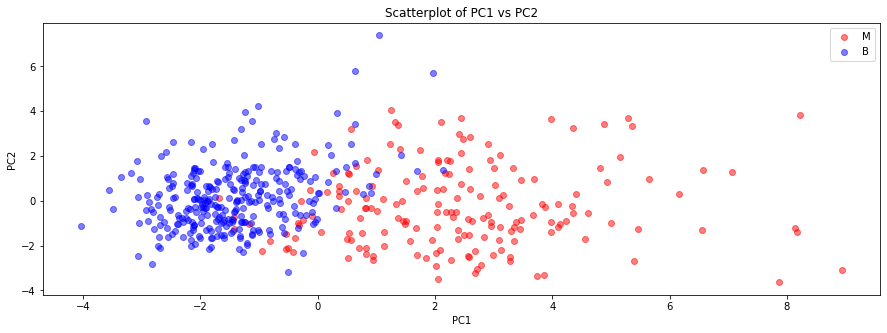

In [445]:
# Create a color map for diagnosis
color_map = {'M': 'red', 'B': 'blue'}
plt.figure(figsize=(15, 5))

for type in ['M', 'B']:
    is_diagnosis = X_train_PCA['diagnosis'] == type
    plt.scatter(X_train_PCA.loc[is_diagnosis, 'PC1'], X_train_PCA.loc[is_diagnosis, 'PC2'], 
                color=color_map[type], alpha=0.5, label=type)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatterplot of PC1 vs PC2')
plt.legend()  # Automatically uses labels specified in plt.scatter
plt.show()


From the scatterplot of PC1 and PC2 above, we can see that there is a clear separation between the benign and malignant tumors. We see that PC1 explains the variance greatly as the benign tumours take on lower PC1 scores, and the malignant ones have higher PC1 scores. If we look at the points along the PC2 axis, they do not show any seperation. Therefore, we can perhaps conclude the PC1 contains the most amount of variance. The variance ratio shows us that PC1 explains 54% of the variance, and PC2 explains 25% of the variance as expected given the scatterplot above. 

In [446]:
# Get the explained variance ratio from the PCA model
variance_ratio = pd.DataFrame(PCA_model.explained_variance_ratio_, columns=['Explained Variance Ratio'], index=PCA_names)
variance_ratio

,Explained Variance Ratio
PC1,0.538165
PC2,0.253507
PC3,0.088867
PC4,0.053371
PC5,0.038925


**4. PC1 and PC2 Biplots/ 5. Biplot Interpretation**

From the PCA model, we have shown that the first 2 principal components explain 79% of the variance in the dataset. Therefore, we can plot a biplot of PC1 and PC2 to see which features are the most important in predicting the tumour status.

In [455]:
# First, we need to create a function to plot the biplots
def biplot2PC(coeff,axs):
    labels = coeff.index
    for i in range(coeff.shape[0]):
        axs.arrow(0, 0, coeff.iloc[i, 0], coeff.iloc[i, 1], head_width=0.01, color='r', alpha=0.4)
        axs.text(coeff.iloc[i, 0]*1.05, coeff.iloc[i, 1]*1.05, labels[i], color='black', ha='center', va='center', fontsize=8)

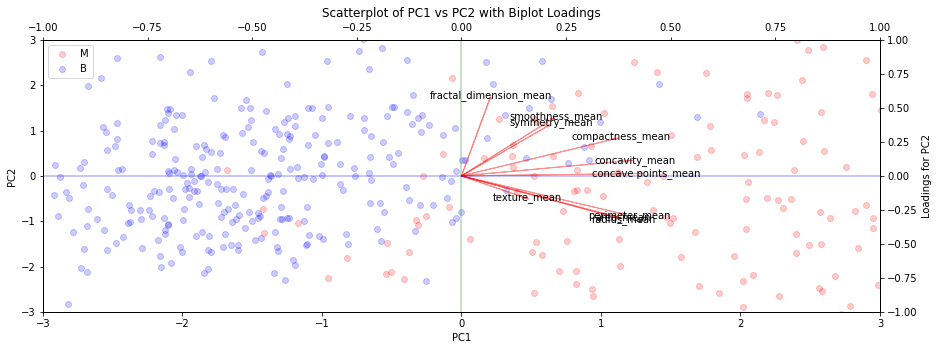

In [476]:
# Scatterplot of PC1 vs PC2 with biplot

fig, ax1 = plt.subplots(1,1)
twin_stacked = ax1.twiny().twinx()

for type in ['M', 'B']:
    is_diagnosis = X_train_PCA['diagnosis'] == type
    ax1.scatter(X_train_PCA.loc[is_diagnosis, 'PC1'], X_train_PCA.loc[is_diagnosis, 'PC2'], 
                color=color_map[type], alpha=0.2, label=type)

loadings = pd.DataFrame(PCA_model.components_.T, columns=PCA_names, index=X_train.columns)
labels = loadings.index

# plot the biplot
for i in range(loadings.shape[0]):
    twin_stacked.arrow(0, 0, loadings.iloc[i, 0], loadings.iloc[i, 1], head_width=0.01, color='r', alpha=0.4)
    twin_stacked.text(loadings.iloc[i, 0]*1.05, loadings.iloc[i, 1]*1.05, labels[i], color='black', ha='center', va='center', fontsize=10)
# add x axes for loadings
twin_stacked.axhline(0, color='blue', alpha=0.3)
twin_stacked.axvline(0, color='green', alpha=0.3)

# change figure limits
ax1.set_xlim(-3, 3)
ax1.set_ylim(-3, 3)
twin_stacked.set_xlim(-1, 1)
twin_stacked.set_ylim(-1, 1)
twin_stacked.figure.set_size_inches(15, 5)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
twin_stacked.set_xlabel('Loadings for PC1')
twin_stacked.set_ylabel('Loadings for PC2')
ax1.set_title('Scatterplot of PC1 vs PC2 with Biplot Loadings')
ax1.legend()
plt.show()

Looking at the scatterplot together with the biplot, we see that PC1 tackles the most variance in the dataset. We also observe that all of the variables are positively correlated to PC1, of varying degrees, where the vectors all point towards the positive side of the PC1 axis, and towards more of the malignant tumors. We can see that the features that contribute the most to PC1 are: Concave points mean, concavity mean and perimeter mean. For PC2, the features that contribute the most are: fractal dimension mean, smoothness mean and symmetry mean.

To see which features are more related to tumour status, we can see that perimeter mean, area mean and radius mean are the most important features in predicting the tumour status. However, seeing that they are so closely correlated to each other, keeping one of them would be sufficient. Smoothness mean and compactness mean might also be important in predicting the tumour status.

To complete our understanding of how each variable contributes to PC1 and PC2, we can look at the feature strengths in model components.

In [433]:
# PC1 vs PC2 feature strength
feature_strength = pd.DataFrame(PCA_model.components_.T, columns=PCA_names, index=X_train.columns)
feature_strength['abs_PC1'] = feature_strength['PC1'].abs()
feature_strength['abs_PC2'] = feature_strength['PC2'].abs()
feature_strength.sort_values(by='abs_PC1', ascending=False, inplace=True)
feature_strength.drop(columns=['abs_PC1', 'abs_PC2'], inplace=True)
feature_strength

,PC1,PC2,PC3,PC4,PC5
concave points_mean,0.420834,0.017094,-0.066982,-0.070246,-0.014636
concavity_mean,0.395966,0.110982,0.054832,-0.188123,0.299313
perimeter_mean,0.381388,-0.276714,-0.119289,0.020237,-0.008159
radius_mean,0.369345,-0.305992,-0.130974,0.037852,-0.033071
area_mean,0.368316,-0.298970,-0.128965,0.020003,-0.025937
compactness_mean,0.364129,0.270729,0.066935,-0.189521,0.235315
smoothness_mean,0.215740,0.416131,-0.186609,-0.069539,-0.841014
symmetry_mean,0.205064,0.364969,0.064668,0.890708,0.145729
texture_mean,0.151007,-0.159990,0.941193,0.000966,-0.253288
fractal_dimension_mean,0.067771,0.567933,0.123130,-0.351165,0.245550


**6. Use the 5 Principal Components as Features in Logistic Regression**

Given that we have found the 5 principal components that explain at least 95% variance in the dataset, we can use these 5 principal components as features in a logistic regression model.

In [434]:
# Building a Logistic Regression Model with PCA, starting with the base model
# Call the X_train and X_test again
X_train_PCA = PCA_model.transform(X_train)
X_test_PCA = PCA_model.transform(X_test)
X_train_PCA = pd.DataFrame(X_train_PCA, columns=PCA_names)
X_test_PCA = pd.DataFrame(X_test_PCA, columns=PCA_names)

# Create the base logistic regression model
lr_pca_base = LogisticRegression(random_state=5508)
lr_pca_base.fit(X_train_PCA, y_train)

# Get predictions for the training and test set
y_train_pred = lr_pca_base.predict(X_train_PCA)
y_test_pred = lr_pca_base.predict(X_test_PCA)
target_names = lr_pca_base.classes_

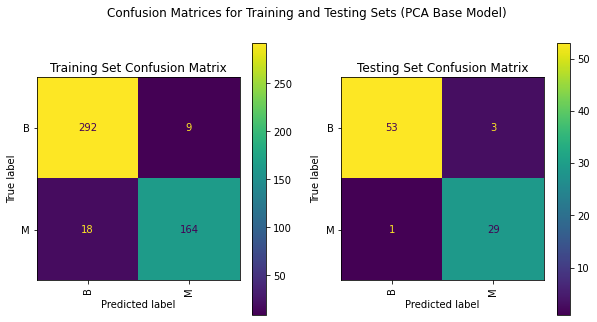

------------------- Model Summary (PCA Base Model) ----------------------
Training Set Report:
              precision    recall  f1-score   support

           B       0.94      0.97      0.96       301
           M       0.95      0.90      0.92       182

    accuracy                           0.94       483
   macro avg       0.94      0.94      0.94       483
weighted avg       0.94      0.94      0.94       483

Testing Set Report:
              precision    recall  f1-score   support

           B       0.98      0.95      0.96        56
           M       0.91      0.97      0.94        30

    accuracy                           0.95        86
   macro avg       0.94      0.96      0.95        86
weighted avg       0.96      0.95      0.95        86



In [435]:
# Model Evaluation using Confusion Matrix and Classification Report
display_confusion_matrix(y_train, y_test, y_train_pred, y_test_pred, target_names, 'PCA Base Model')
print("------------------- Model Summary (PCA Base Model) ----------------------")
summarize_classification(y_train, y_test, y_train_pred, y_test_pred, target_names)

In [436]:
# Likewise, we try to find the optimal hyperparameters to give us the best model with recall on Maligant.

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear', 'saga'],
                'class_weight': ['balanced', None],
}

lr_optim_pca_cv = GridSearchCV(bc_logreg_base, param_grid, cv=5, scoring = make_scorer(recall_score, pos_label='M'), n_jobs=-1)
lr_optim_pca_cv.fit(X_train_PCA.values, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=10000, random_state=5508),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring=make_scorer(recall_score, pos_label=M))

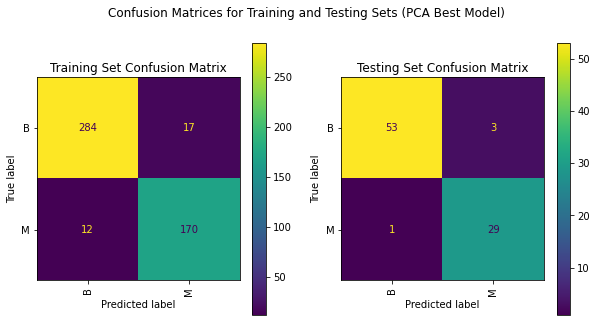

------------------- Model Summary (PCA Best Model) ----------------------
Training Set Report:
              precision    recall  f1-score   support

           B       0.96      0.94      0.95       301
           M       0.91      0.93      0.92       182

    accuracy                           0.94       483
   macro avg       0.93      0.94      0.94       483
weighted avg       0.94      0.94      0.94       483

Testing Set Report:
              precision    recall  f1-score   support

           B       0.98      0.95      0.96        56
           M       0.91      0.97      0.94        30

    accuracy                           0.95        86
   macro avg       0.94      0.96      0.95        86
weighted avg       0.96      0.95      0.95        86



In [437]:
# Best model for PCA
lr_optim_pca = lr_optim_pca_cv.best_estimator_
lr_optim_pca.fit(X_train_PCA, y_train)

# Get predictions for the training and test set
y_train_best = lr_optim_pca.predict(X_train_PCA)
y_test_best = lr_optim_pca.predict(X_test_PCA)

display_confusion_matrix(y_train, y_test, y_train_best, y_test_best, target_names, 'PCA Best Model')
print("------------------- Model Summary (PCA Best Model) ----------------------")
summarize_classification(y_train, y_test, y_train_best, y_test_best, target_names)

In [438]:
# Look at the best parameters 
lr_optim_pca_cv.best_params_

{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

If we compare the results on the base model and the optimal model we can observe that there is an increase in recall scores for the malignant tumors. This is apparent in the training set, but in the test set, it remains the same. We pick the optimal model as it is better at catching the malignant tumors correctly without sacrificing generalisation to the test set.

Comparing the optimal model by using the 5 PCs and the regular scaled data, we can observe that there is not any significant different between the 2 results. In fact, the PCA model might have done slightly better in the test set. Reducing the feature dimension down to the 5 principal components might have helped the model to generalise better to the test set. Therefore, PCA might be a good option to use before fitting a logistic regression model.